In [151]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [152]:
# check current directory
import pathlib
pathlib.Path.cwd()

PosixPath('/Users/viv/Documents/Code/AnomalyDetectionPCADemo')

In [153]:
data_dir = 'sample_data'
filename = 'creditcardfraud_orig.csv'

#dataset = pd.read_csv(os.path.join(data_dir, filename))
dataset = pd.read_csv(filename)
dataset = dataset.rename(columns = {"class": "Class"})
dataset

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.756448,0.873531,0.666991,0.160317,0.729603,0.236810,0.235393,0.863749,0.528729,0.598850,...,0.564920,0.515249,0.680500,0.313600,0.658558,0.466291,0.433929,0.329840,0.000030,0
284803,0.945845,0.766677,0.872678,0.219189,0.771561,0.273661,0.265504,0.788548,0.482925,0.488530,...,0.564933,0.553154,0.665619,0.245298,0.543855,0.360884,0.417775,0.312038,0.000965,0
284804,0.990905,0.764080,0.781102,0.227202,0.783425,0.293496,0.263547,0.792985,0.477677,0.498692,...,0.565220,0.537005,0.664877,0.468492,0.592823,0.411176,0.416593,0.312585,0.002642,0
284805,0.954209,0.772856,0.849587,0.282508,0.763172,0.269291,0.261175,0.792671,0.476287,0.500464,...,0.565755,0.547353,0.663008,0.398836,0.545958,0.514746,0.418520,0.315245,0.000389,0


In [154]:
# Separate input features and target
y = dataset.Class
feature_data = dataset.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(feature_data, y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=27)

# concatenate training data back together
train_data = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud_train = train_data[train_data.Class==0]
fraud_train = train_data[train_data.Class==1]

# upsample minority
fraud_upsamp_train = resample(fraud_train,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud_train), # match number in majority class
                          random_state=517) # reproducible results

# combine majority and upsampled minority
train_upsamp = pd.concat([not_fraud_train, fraud_upsamp_train])

# check new class counts
print(train_upsamp.Class.value_counts())

train_upsamp = resample(train_upsamp, n_samples=10*6)

X_train = train_upsamp.drop('Class', axis=1)
y_train = train_upsamp.Class

1    227451
0    227451
Name: Class, dtype: int64


In [155]:
plot_data = [[0,0,0],[0,0,0]]
layer_sizes = np.arange(2,30)

for size in layer_sizes:
    clf = MLPClassifier(activation = 'relu',
                        solver = 'adam',
                        #verbose = True,
                        learning_rate_init = 10**-3,
                        learning_rate = 'adaptive',
                        alpha = 10**-3*3, # penalty (regularization term)
                        #early_stopping = True,  # default is False, true does not yeild good results
                        epsilon = 10**-8, # Value for numerical stability in adam
                        random_state=517,
                        max_iter=10**4, # Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.
                        hidden_layer_sizes = [size, size, size]).fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    temp_acc, temp_precis, temp_recall = clf.score(X_test, y_test), metrics.accuracy_score(y_test, y_pred), metrics.recall_score(y_test, y_pred)
    print(size)
    # mean accuracy on the given test data and labels
    print(clf.score(X_test, y_test))
    print("Accuracy:",temp_acc)
    # Precision: percentage of predicted frauds that are actually fraud
    print("Precision:",temp_precis)
    # Recall: percentage actual frauds predicted as fraud
    print("Recall:",temp_recall,"\n")

    plot_data = np.vstack((plot_data, [temp_acc, temp_precis, temp_recall]))

2
0.9990168884519505
Accuracy: 0.9990168884519505
Precision: 0.9990168884519505
Recall: 0.7959183673469388 

3
0.9732628770057231
Accuracy: 0.9732628770057231
Precision: 0.9732628770057231
Recall: 0.9285714285714286 

4
0.9732277658790071
Accuracy: 0.9732277658790071
Precision: 0.9732277658790071
Recall: 0.9285714285714286 

5
0.9971208876092834
Accuracy: 0.9971208876092834
Precision: 0.9971208876092834
Recall: 0.826530612244898 

6
0.9141532951792423
Accuracy: 0.9141532951792423
Precision: 0.9141532951792423
Recall: 0.9489795918367347 

7
0.8850812822583477
Accuracy: 0.8850812822583477
Precision: 0.8850812822583477
Recall: 0.9489795918367347 

8
0.8916997296443243
Accuracy: 0.8916997296443243
Precision: 0.8916997296443243
Recall: 0.9387755102040817 

9
0.9478775323900144
Accuracy: 0.9478775323900144
Precision: 0.9478775323900144
Recall: 0.8775510204081632 

10
0.8860292826796812
Accuracy: 0.8860292826796812
Precision: 0.8860292826796812
Recall: 0.9489795918367347 

11
0.88560794915908

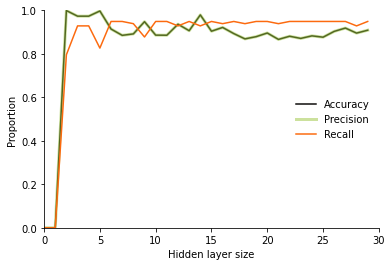

In [156]:
plot_data = pd.DataFrame(plot_data, columns = ['Accuracy','Precision','Recall'])
ind = np.arange(30)
ax = plt.subplot(111)

ax.plot(ind, plot_data['Accuracy'], label="Accuracy", color = "#0A0908")
ax.plot(ind, plot_data['Precision'], label="Precision", color = "#9BC53D", alpha = .5, linewidth = 3)
ax.plot(ind, plot_data['Recall'], label="Recall", color = "#FC6A0F")
ax.legend(loc = 'center right', edgecolor = "white")

plt.xlim(0, 30)
plt.ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Proportion')
plt.xlabel('Hidden layer size')

plt.savefig("NN1_fig", dpi = 10**3, transparent=False)
plt.show()